In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carga del dataset

Utilizando spark se realizo una partición del 2.5% de los datos del dataset original.

In [3]:
with open("header.txt", "r") as f:
    line = f.readline()
    cols = line.split(",")
    
df = pd.read_csv("data_sample.csv", header = None, sep = ",", names = cols)
df.head()

,periodo,id_cli,fecha_nacimiento,edad,genero,estado_civil,nivel_academico,profesion,ocupacion,tipo_vivienda,...,cuota_libranza_sf,cant_oblig_tot_sf,cant_cast_ult_12m_sr,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,202003,2089776,19840630,35.638604,M,DIVORCIADO,TECNOLOGO,TECNOLOGIA SISTEMAS,Empleado,ALQUILADA,...,0.0,0.0,0.0,695516.000,C,0.0,\N,1255032.0,NaN,304687.00
1,201902,2088089,19860727,32.476386,M,UNION LIBRE,NO INFORMA,\N,Independiente,FAMILIAR,...,0.0,NaN,NaN,1187025.000,SIN INFO,NaN,\N,NaN,NaN,187990.00
2,202001,3892351,19910108,28.936345,M,SOLTERO,TECNOLOGO,OTROS,Independiente,\N,...,0.0,NaN,NaN,3879251.250,SIN INFO,NaN,\N,NaN,NaN,862348.92
3,202008,2897552,19900903,29.883641,M,SOLTERO,BACHILLER,\N,Empleado,\N,...,0.0,0.0,1.0,210681.475,F,7.0,\N,NaN,1484205.0,1056864.00
4,202001,4782141,19790623,40.481862,F,NO INFORMA,SIN INFORMACION,\N,Empleado,\N,...,0.0,4.0,0.0,1615755.800,C,0.0,70831,4353538.0,3500000.0,248386.00


### Las siguientes variables no serán utilizadas dado que no aportan información relevante para el problema



In [6]:
df = df.drop(["periodo","id_cli","fecha_nacimiento","ult_actual","codigo_ciiu", "profesion",
              "departamento_residencia", "departamento_laboral", "convenio_lib","nro_tot_cuentas", 
              "ctas_embargadas", "ctas_activas", "ingreso_nompen", "cupo_tc_mdo", "cant_cast_ult_12m_sr", 
              "ingreso_nomina", "ingreso_segurida_social", "pol_centr_ext"], axis = 1)

KeyError: "['periodo' 'id_cli' 'fecha_nacimiento' 'ult_actual' 'codigo_ciiu'\n 'profesion' 'departamento_residencia' 'departamento_laboral'\n 'convenio_lib' 'nro_tot_cuentas' 'ctas_embargadas' 'ctas_activas'\n 'ingreso_nompen' 'cupo_tc_mdo' 'cant_cast_ult_12m_sr' 'ingreso_nomina'\n 'ingreso_segurida_social' 'pol_centr_ext'] not found in axis"

In [7]:
df.shape

(432104, 47)

## Tratamiento de variables categoricas

In [8]:
df = df[df["rep_calif_cred"] != "SIN INFO"]
df = df[df["genero"] != " "]
df = df.dropna(subset = ["categoria", "edad"])

In [9]:
def clean_civil_status(x: str) -> str:
    if x == "NO INFORMA" or x == "\\N": return "otro"
    return x.lower()

def clean_academic_level(x: str) -> str:
    if x == "NO INFORMA": return "sin informacion"
    return x.lower()

def clean_house_kind(x: str) -> str:
    if x == "\\N": return "no informa"
    return x.lower()

def clean_occupation(x: str) -> str:
    if x == "\\N" or x == "Sin Ocupacion Asignada" or x == "Vacío":
        return "otro"
    return x.lower()

def clean_cat_income(x: str) -> str:
    if x == "\\N": return "ninguno"
    return x

In [10]:
df["estado_civil"] = df["estado_civil"].apply(clean_civil_status)
df["nivel_academico"] = df["nivel_academico"].apply(clean_academic_level)
df["tipo_vivienda"] = df["tipo_vivienda"].apply(clean_house_kind)
df["ocupacion"] = df["ocupacion"].apply(clean_occupation)
df["cat_ingreso"] = df["cat_ingreso"].apply(clean_cat_income)

In [11]:
df["cat_ingreso"].value_counts()

ninguno    221679
NOM        145219
PEN         23634
NOM PEN      1396
Name: cat_ingreso, dtype: int64

### Binarización de variables

En esta etapa además de limpiar las variables categoricas, se van a binarizar las que se utilizaran para el modelo

In [12]:
def binarize_yes_no(x: str) -> int:
    if x == "S" or x == "SI" or x == "X": return 1
    return 0

def binarize_genre(x: str) -> int:
    if x == "M": return 1
    return 0

def binarize_credit_refused(x: str) -> int:
    if x == "\\N": return 0
    return 1

def binarize_mora(x: float) -> int:
    if x > 0: return 1
    return 0
    

In [13]:
df["ind_mora_vigente"] = df["ind_mora_vigente"].apply(binarize_yes_no)
df["cartera_castigada"] = df["cartera_castigada"].apply(binarize_yes_no)
df["tenencia_tc"] = df["tenencia_tc"].apply(binarize_yes_no)
df["tiene_consumo"] = df["tiene_consumo"].apply(binarize_yes_no)
df["tiene_crediagil"] = df["tiene_crediagil"].apply(binarize_yes_no)
df["tiene_ctas_activas"] = df["tiene_ctas_activas"].apply(binarize_yes_no)
df["tiene_ctas_embargadas"] = df["tiene_ctas_embargadas"].apply(binarize_yes_no)
df["pension_fopep"] = df["pension_fopep"].apply(binarize_yes_no)
df["tiene_cred_hipo_1"] = df["tiene_cred_hipo_1"].apply(binarize_yes_no)
df["tiene_cred_hipo_2"] = df["tiene_cred_hipo_2"].apply(binarize_yes_no)
df["genero"] = df["genero"].apply(binarize_genre)
df["rechazo_credito"] = df["rechazo_credito"].apply(binarize_credit_refused)
df["cant_moras_30_ult_12_meses"] = df["cant_moras_30_ult_12_meses"].apply(binarize_mora)
df["cant_moras_60_ult_12_meses"] = df["cant_moras_60_ult_12_meses"].apply(binarize_mora)
df["cant_moras_90_ult_12_meses"] = df["cant_moras_90_ult_12_meses"].apply(binarize_mora)
df["cant_mora_30_tdc_ult_3m_sf"] = df["cant_mora_30_tdc_ult_3m_sf"].apply(binarize_mora)
df["cant_mora_30_consum_ult_3m_sf"] = df["cant_mora_30_consum_ult_3m_sf"].apply(binarize_mora)

### Categorización de la edad

In [14]:
def age_categorization(x: float) -> str:
    if x <= 27: return "Z"
    elif 27 < x <= 40: return "Y"
    elif 40 < x <= 52: return "X"
    else: return "BB"

In [15]:
df["edad"] = df["edad"].apply(age_categorization)

df = df.drop(["ciudad_residencia","ciudad_laboral"], axis = 1)

## Tratamiento de varibales numericas

In [16]:
def clean_cuota_consumo(x: float) -> float:
    if x < 0: return -1 * x
    return x

In [17]:
df["cuota_de_consumo"] = df["cuota_de_consumo"].apply(clean_cuota_consumo)

In [18]:
df["cuotas_pagadas"] = df["cuota_de_vivienda"] + df["cuota_de_consumo"] + df["cuota_rotativos"] \
                        + df["cuota_tarjeta_de_credito"] + df["cuota_de_sector_solidario"] \
                        + df["cuota_sector_real_comercio"] + df["cuota_tc_mdo"] +df["cuota_tc_bancolombia"] \
                        + df["cuota_cred_hipot"] + df["cuota_libranza_sf"]
df = df.drop(["cuota_de_vivienda", "cuota_de_consumo", "cuota_rotativos",
              "cuota_tarjeta_de_credito", "cuota_de_sector_solidario",
              "cuota_sector_real_comercio", "cuota_tc_mdo", "mora_max",
              "cupo_total_tc", "cuota_tc_bancolombia", "cuota_cred_hipot", "cuota_libranza_sf"], axis = 1)

### One Hot encoding

In [19]:
categorical = df.select_dtypes(include=['object'])
categorical

,edad,estado_civil,nivel_academico,ocupacion,tipo_vivienda,cat_ingreso,rep_calif_cred
0,Y,divorciado,tecnologo,empleado,alquilada,NOM,C
3,Y,soltero,bachiller,empleado,no informa,ninguno,F
4,X,otro,sin informacion,empleado,no informa,NOM,C
5,Y,soltero,tecnologo,empleado,no informa,ninguno,C
6,BB,casado,universitario,empleado,familiar,PEN,B
...,...,...,...,...,...,...,...
432099,Z,soltero,bachiller,estudiante,no informa,ninguno,D
432100,Y,otro,sin informacion,empleado,no informa,ninguno,G
432101,Y,union libre,tecnologo,empleado,no informa,NOM,E
432102,BB,otro,sin informacion,jubilado,no informa,PEN,H


In [20]:
categories = list(categorical.columns)
categories

['edad',
 'estado_civil',
 'nivel_academico',
 'ocupacion',
 'tipo_vivienda',
 'cat_ingreso',
 'rep_calif_cred']

In [21]:
cat_df = pd.get_dummies(df, prefix=categories)
cat_df

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_PEN,cat_ingreso_ninguno,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
0,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,1,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,1,2.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432099,1,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
432100,1,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
432101,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
432102,1,1.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


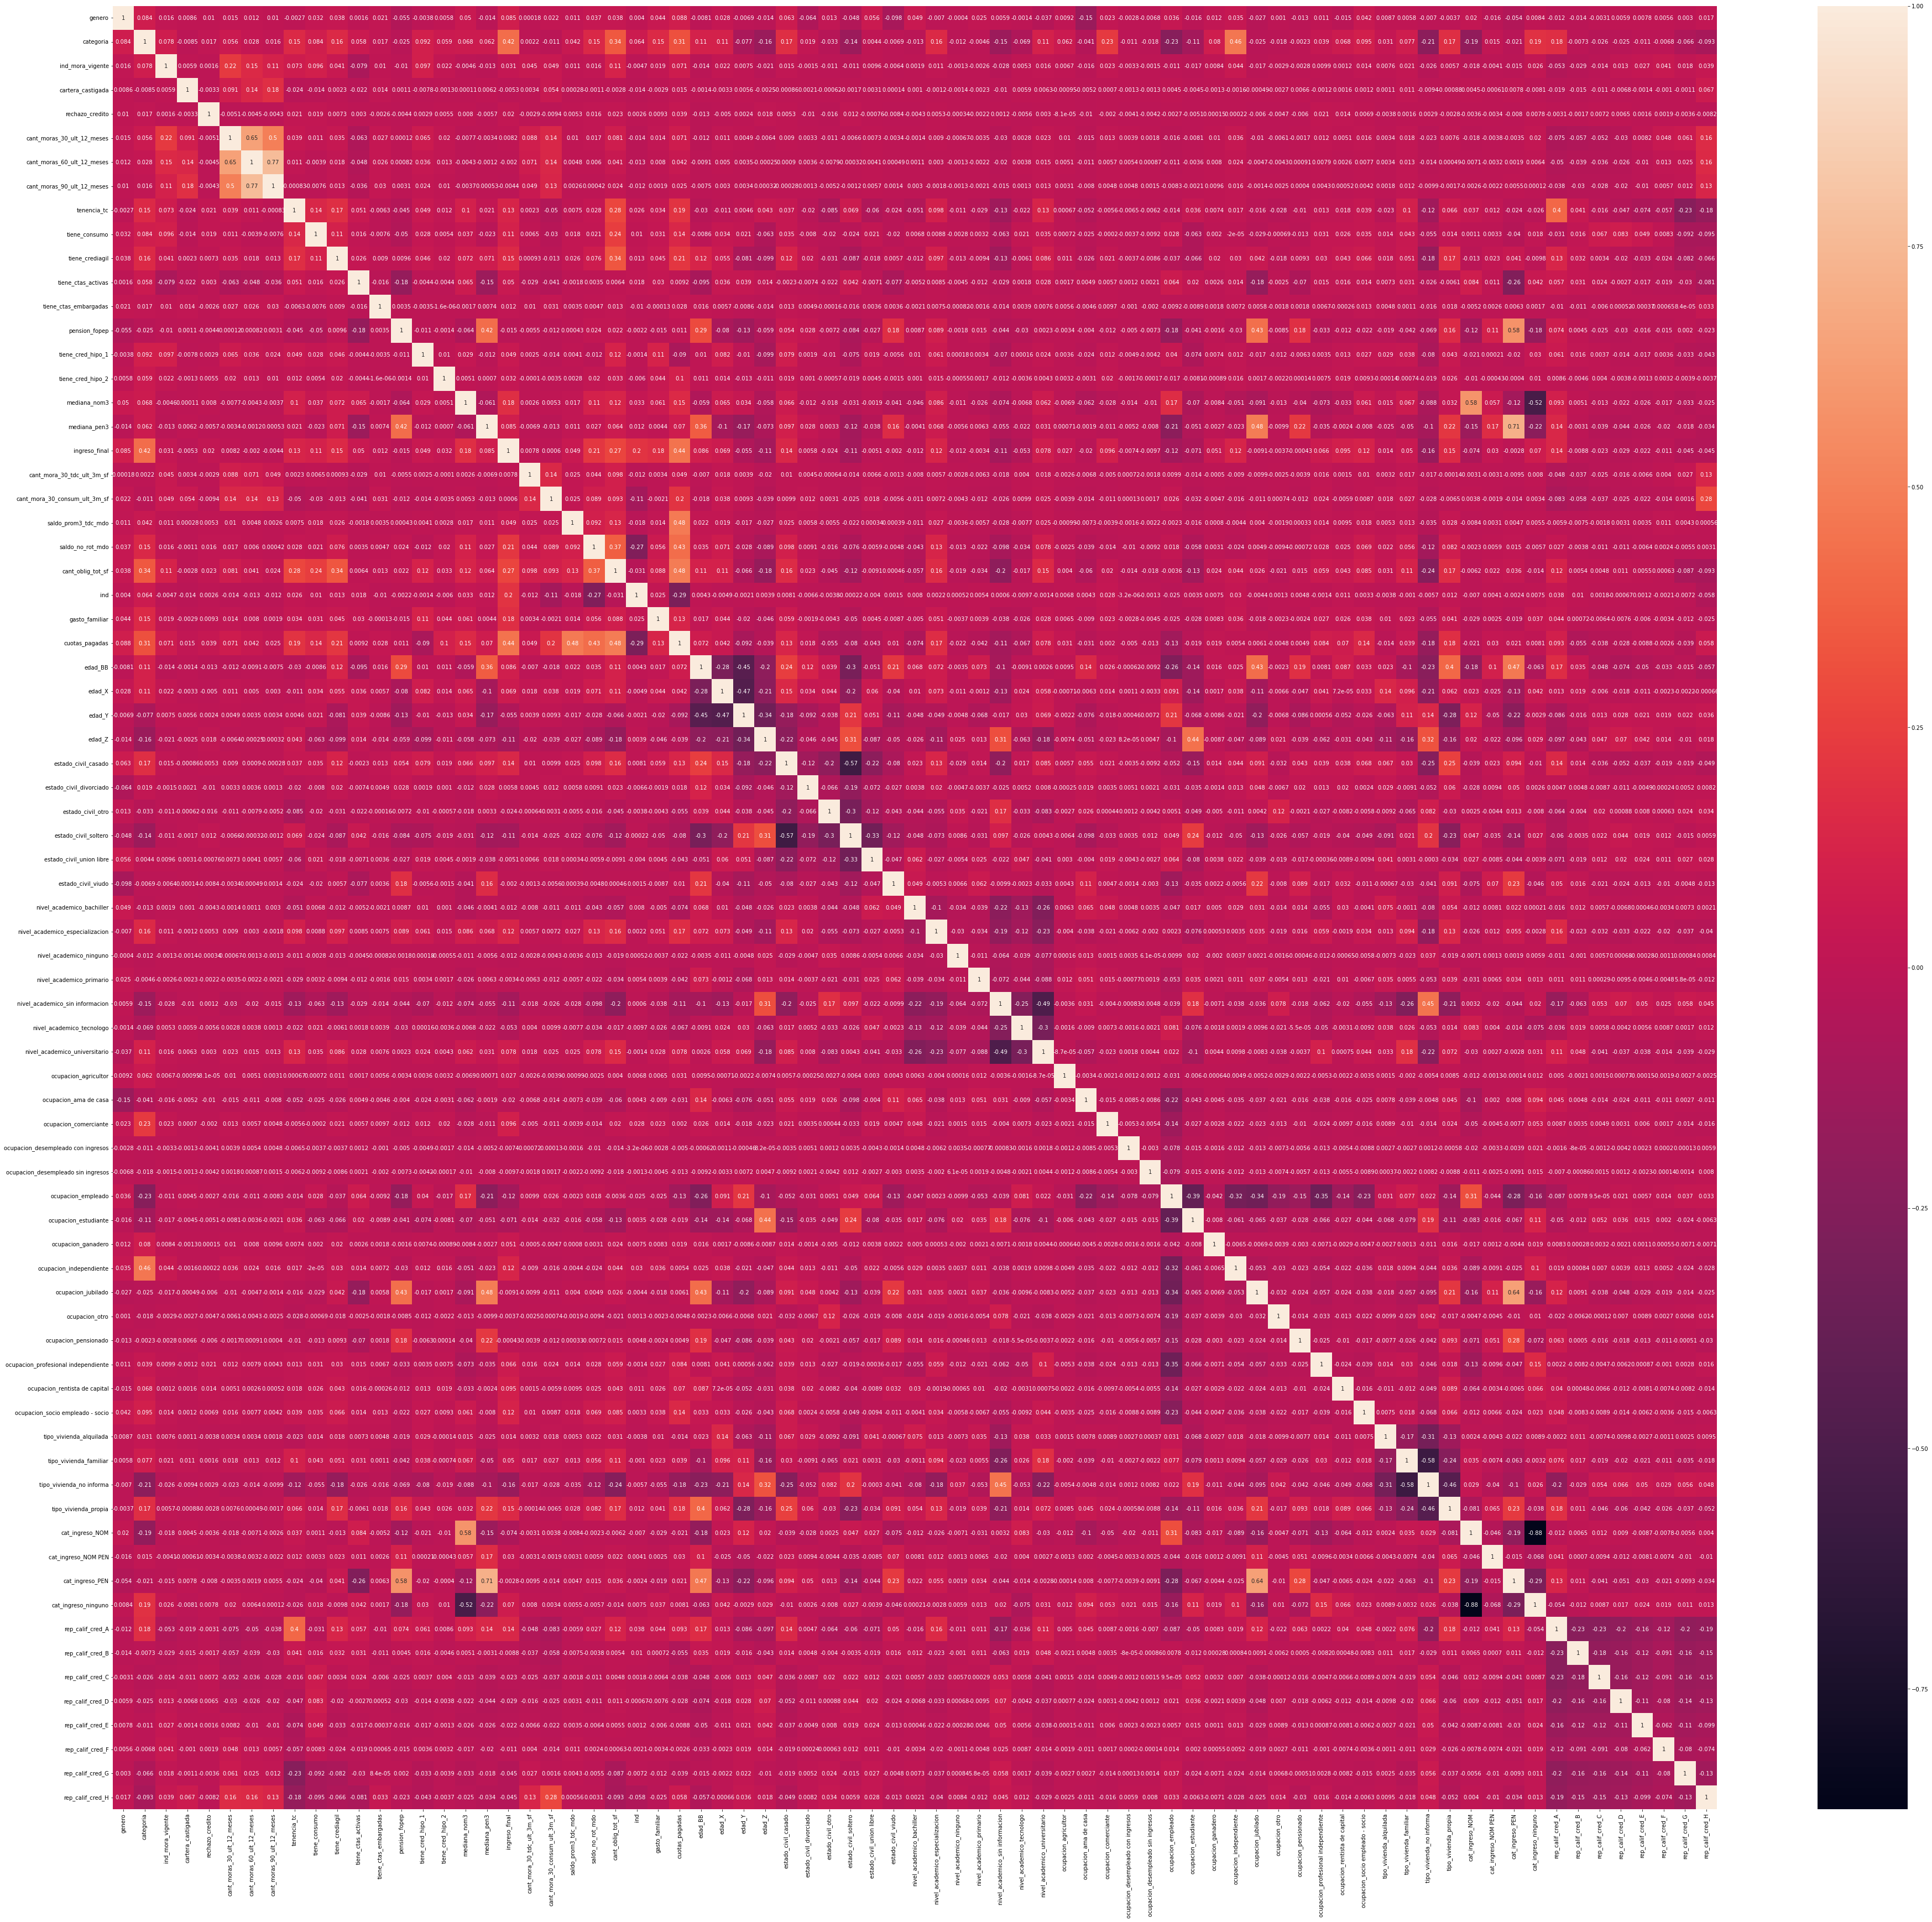

In [22]:
plt.figure(figsize = (65,60))
corrMatrix = cat_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Imputación de valores nulos

In [23]:
cat_df = cat_df.fillna(0)

### Eliminación de Outliers

In [24]:
max_val = cat_df.gasto_familiar.quantile(0.95)
min_val = cat_df.gasto_familiar.quantile(0.05)

cat_df = cat_df[(cat_df['gasto_familiar'] > min_val) & (cat_df['gasto_familiar']< max_val)]

## Modelos

In [29]:
cat_df.describe()

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_PEN,cat_ingreso_ninguno,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
count,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,...,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000,348220.000000
mean,0.488364,1.468890,0.022948,0.001752,0.005430,0.020045,0.008535,0.005132,0.414031,0.134027,...,0.060413,0.553386,0.223178,0.153728,0.153406,0.122615,0.076997,0.043834,0.122285,0.103957
std,0.499865,0.775924,0.149738,0.041817,0.073491,0.140154,0.091989,0.071453,0.492555,0.340682,...,0.238251,0.497143,0.416377,0.360688,0.360379,0.327995,0.266588,0.204727,0.327615,0.305206
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Divisón del dataset

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

scoring = ["r2", "neg_mean_absolute_percentage_error"]

In [26]:
X = cat_df.drop(["gasto_familiar"], axis = 1)
Y = cat_df["gasto_familiar"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 11)

### ElasticNet

#### ElasticNect Train/Test Split (70/30)

In [79]:
ENReg = ElasticNetCV(random_state = 0)
print(ENReg)
ENReg.fit(X_train, y_train)

ElasticNetCV(random_state=0)


ElasticNetCV(random_state=0)

In [81]:
ENReg_pred = ENReg.predict(X_test)

In [82]:
print(f"R2 Score: {r2_score(y_test, ENReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, ENReg_pred)}")

R2 Score: 0.04814934216695932
MAPE Score: 101.43252013372664


#### ElasticNet con cross validate

In [84]:
scores = cross_validate(ENReg, X, Y, return_train_score = True, cv=5, scoring = scoring)

In [86]:
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.05059578654146981
Test r2 score: 0.049714518834689206
Entrenamiento nMAPE score: -107.44198274973235
Test nMAPE score: -107.56078809421649


### Gradient Boost Tree

#### GBT Train/Test (70/30)

In [33]:
GBReg = GradientBoostingRegressor(n_estimators=50, 
                                  max_depth = 6,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 297085229800.6196  6844879010.5247           46.10s
         2 292578207999.4796  5525193874.8069           45.45s
         3 286902509944.9120  4535625415.2144           44.16s
         4 284171752189.3392  3695136841.1067           43.19s
         5 282246953865.4009  2997648914.9833           42.12s
         6 277047022855.7618  2482399384.0417           41.31s
         7 274864096312.5262  1976121546.1135           40.40s
         8 273593014569.7306  1629929192.8500           39.49s
         9 275260594021.3275  1353924404.6308           38.52s
        10 270825594609.4922  1100914791.7489           37.62s
        11 269753194566.6558   894416576.3765           36.71s
        12 269422591802.6610   754915773.1844           35.73s
        13 268863203505.0829   670059356.6382           34.83s
        14 269321006322.7254   527516844.3995           33.86s
        15 267141623494.4141   435084213.1463          

In [34]:
GBReg_pred1 = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: 0.1227665327687848
MAPE Score: 6.54685689538966


In [29]:
GBReg = GradientBoostingRegressor(n_estimators=300, 
                                  max_depth = 15,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 290248567823.8345  6974869607.9065           10.40m
         2 281424852762.7626  5570006859.1243           10.33m
         3 274471141632.2471  4455428466.2596           10.36m
         4 267157406164.0435  3506792902.2435           10.28m
         5 260794966354.6179  2943035510.4823           10.27m
         6 254261773055.9709  2225302610.3926           10.20m
         7 252800018017.6689  1656423605.0911           10.19m
         8 247740019143.3701  1280743617.1734           10.18m
         9 241066371331.5717   930858798.4379           10.16m
        10 239872924160.1267   753169584.0928           10.13m
        11 237515284622.9398   424384141.2665           10.10m
        12 234331091075.7322   443156077.0604           10.08m
        13 231441980602.6523   316815859.4849           10.06m
        14 228609971213.5519   206670000.8321           10.04m
        15 227717609811.5588    84014718.2919          

In [30]:
GBReg_pred = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: 0.041077552721877963
MAPE Score: 87.5456051795059


In [29]:
GBReg = GradientBoostingRegressor(n_estimators=500, 
                                  max_depth = 30,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 259314396135.1307  5225672780.8846           26.69m
         2 236750374634.0996  4226932283.2761           26.41m
         3 218101113763.4843  3078197447.5849           26.32m
         4 201405200749.6570  2100425252.6972           26.46m
         5 185798850482.4583  1625945193.3416           26.56m
         6 172045465732.0099  1199442894.8006           26.51m
         7 161730354003.6757   339821792.1720           26.53m
         8 150120242536.0269   314927451.8648           26.58m
         9 140156559245.1725    21381366.5006           26.62m
        10 133554083643.7477   -46434465.9508           26.70m
        11 126078098151.8207  -244928107.7283           26.79m
        12 118726790699.1316  -346526567.1750           26.84m
        13 110649340319.3637  -549901538.6530           26.80m
        14 105481155965.1111  -519388325.3868           26.83m
        15 100297690314.1541  -561131321.2963          

In [30]:
GBReg_pred = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: -0.016839592948105553
MAPE Score: 70.7241111850848


#### GBT Cross validate

##### Modelo sencillo

In [87]:
GBReg = GradientBoostingRegressor(n_estimators=50, 
                                  max_depth = 6,
                                  random_state = 101,
                                  subsample = 0.5,)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.1380759752753196
Test r2 score: 0.124359535558213
Entrenamiento nMAPE score: -111.71882303862367
Test nMAPE score: -109.09888593943761


##### Modelo de complejidad intermedia

In [88]:
GBReg = GradientBoostingRegressor(n_estimators=300, 
                                  max_depth = 15,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.705088427224768
Test r2 score: 0.039646741428743006
Entrenamiento nMAPE score: -46.42999000547872
Test nMAPE score: -109.17267897293894


##### Modelo de complejidad alta

In [34]:
cat_df["gasto_familiar"].describe()

count    3.482200e+05
mean     6.099175e+05
std      5.524840e+05
min      3.000000e-02
25%      2.070000e+05
50%      4.302685e+05
75%      8.343360e+05
max      2.684463e+06
Name: gasto_familiar, dtype: float64

In [36]:
2.070000e+05

207000.0

In [28]:
GBReg = GradientBoostingRegressor(n_estimators=500, 
                                  max_depth = 60,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 245948270329.1736  4887199421.7128           36.15m
         2 219442987730.9920  4006781791.5070           36.76m
         3 199349657559.3676  2773432341.7294           36.89m
         4 180314339576.0031  1703238262.6850           37.72m
         5 162563373872.9567  1078430008.3776           38.06m
         6 146439271515.6485   621844501.8446           38.53m
         7 131630651857.5973   271365919.4763           38.58m
         8 119916810822.3296   -11064242.9099           38.60m
         9 108369956071.0228  -462708909.1793           38.75m
        10 98191619270.5001  -412682058.1597           38.85m
        11 88412378981.7445  -550466909.0254           39.01m
        12 80794786468.0762  -611764724.5399           39.29m
        13 73566354370.8627  -611389228.2634           39.70m
        14 67407491269.9940  -719130036.1152           40.15m
        15 61426553477.2169  -759511748.2063           40.33

KeyboardInterrupt: 

#### Evaluación gráfica del modelo más óptimo

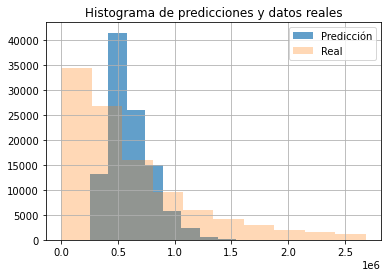

In [44]:
plt.hist(GBReg_pred1, alpha=0.7, label='Predicción')
plt.hist(y_test, alpha=0.3, label='Real')
plt.legend(loc='upper right')
plt.grid()
plt.title("Histograma de predicciones y datos reales");
plt.savefig("histogramaDePredicciones.png")

In [46]:
residuals = y_test - GBReg_pred
ap_residuals = np.abs(residuals) / y_test
lap_residuals = np.log(ap_residuals)

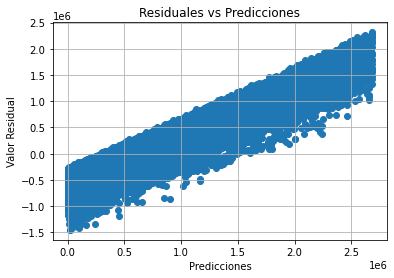

In [51]:
plt.scatter(y_test,residuals);
plt.xlabel("Predicciones");
plt.ylabel("Valor Residual");
plt.grid();
plt.title("Residuales vs Predicciones");
plt.savefig("residualesVpredicciones.png")

Text(0.5, 1.0, 'Residuales absoltutos vs Predicciones')

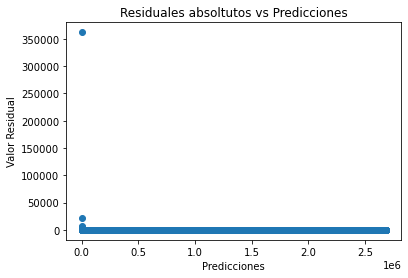

In [53]:
plt.scatter(y_test,ap_residuals);
plt.xlabel("Predicciones")
plt.ylabel("Valor Residual")
plt.title("Residuales absoltutos vs Predicciones")

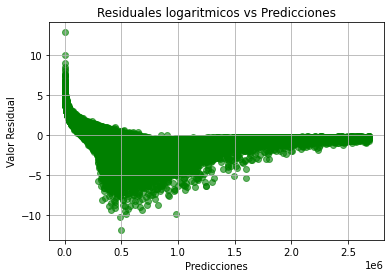

In [60]:
plt.scatter(y_test,lap_residuals, color="g", alpha = 0.6);
plt.xlabel("Predicciones")
plt.ylabel("Valor Residual")
plt.grid()
plt.title("Residuales logaritmicos vs Predicciones")
plt.savefig("residualesLogaritmicos.png")

### Support Vector Machine (SVR)

#### SVR Train/Test Split (70/30)

##### Kernel Lineal

In [ ]:
svr = SVR(kernel = "linear", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

##### Kernel Polinomial

In [ ]:
svr = SVR(kernel = "poly", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

##### Kernel RBF

In [ ]:
svr = SVR(kernel = "rbf", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

Debido a la alta complejidad del modelo, y los costos computacionales para los calculos, el SVR solo se utilizará en validación Train/Test Split